## Self-Training on a Classical Model
    Amin Ahmadi
    date created: 16 June 2022
    last update: 28 June 2022

### TODO
 - [ ] Train a classical model.
 - [ ] Reduce the labeled dataset until there is a sudden drop in the performance
 - [ ] Feeding ulabeled dataset and increase the volume, observe change in the performance
 - [ ] If it is fluctuating too much run for many realization take the average
 
### Questions to Answer
- [ ] Critical(maximum) volume for the labeled data set that it can benefit from self-training
- [ ] Maximum volume for unlabeled dataset befor saturation or drop in performance due to noise.

In [1]:
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as pl

from sklearn.metrics import roc_auc_score, \
                            auc,\
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            classification_report

In [2]:
from sklearn.semi_supervised import SelfTrainingClassifier

In [3]:
df_train_raw = pd.read_parquet('../data/imdb_train.parq', 
                           engine='pyarrow')
df_test_raw = pd.read_parquet('../data/imdb_test.parq', 
                          engine='pyarrow')

## Use labeled as unlabeled dataset
Since the unlabeled dataset may have a different review score than the labeled dataset, we set a side part of L and treat them as U.
- filter out all originally U
- take 50% of L as U
- if there is any positive signal we can investigate the effect of context on self-training

## In deep learning
- what if the embedding layer is trained on U
- the actual clasifier on L

In [4]:
df_train_raw = df_train_raw[df_train_raw['review'] != 'unsup'].copy()
df_train_raw.shape

(25000, 2)

In [5]:
df_U, df_L = train_test_split(df_train_raw,test_size=0.5, random_state=42)
df_U.shape, df_L.shape

((12500, 2), (12500, 2))

In [6]:
label_map_l = {'pos':1, 'neg':0}
df_U.loc[:, 'label'] = -1
df_L.loc[:, 'label'] = df_L['review'].map(label_map_l)
df_test_raw.loc[:, 'label'] = df_test_raw['review'].map(label_map_l)
# sample for testing from original test
df_test = df_test_raw.copy()
df_train = pd.concat([df_U, df_L])

/Users/cm-amin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [7]:
df_train.groupby(['review'])['label'].value_counts()

review  label
neg     -1       6308
         0       6192
pos      1       6308
        -1       6192
Name: label, dtype: int64

### Classical Model

In [8]:
cl = Pipeline([('vectorizer', TfidfVectorizer()),
          ('clf', SGDClassifier(loss='log'))]) # for self-training prob. is needed

In [9]:
df_L_sample = df_L.sample(frac=0.1)
df_train_sample = df_train.sample(frac=0.1)

In [10]:
df_train_sample.head()

,text,review,label
9709,Shortly after seeing this film I questioned th...,neg,0
1294,"I was very excited about seeing this film, ant...",neg,-1
6493,"Some amusing humor, some that falls flat, some...",neg,0
11331,It begins on a nice note only to falter quickl...,neg,-1
2301,Rohmer strays from his usual portraits of fren...,pos,1


In [16]:
cl.fit(df_L_sample['text'], df_L_sample['label'])

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('clf', SGDClassifier(loss='log'))])

In [17]:
train_prediction = cl.predict(df_L_sample['text'])
test_prediction = cl.predict(df_test['text'])

In [18]:
print(classification_report(df_L_sample['label'], train_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       601
           1       1.00      1.00      1.00       649

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



In [19]:
print(classification_report(df_test['label'], test_prediction))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     12500
           1       0.80      0.88      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



### Self-Training on Logistic Regression

In [20]:
# for self-training prediction prob. is needed ==> loss='log'
sgd = SGDClassifier(loss='log', n_jobs=-1)
cl_self = Pipeline([('vectorizer', TfidfVectorizer()),
          ('self-clf', SelfTrainingClassifier(sgd, threshold=0.9))])

In [21]:
df_train_sample.head()

,text,review,label
9709,Shortly after seeing this film I questioned th...,neg,0
1294,"I was very excited about seeing this film, ant...",neg,-1
6493,"Some amusing humor, some that falls flat, some...",neg,0
11331,It begins on a nice note only to falter quickl...,neg,-1
2301,Rohmer strays from his usual portraits of fren...,pos,1


In [22]:
cl_self.fit(df_train_sample['text'], df_train_sample['label'])

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('self-clf',
                 SelfTrainingClassifier(base_estimator=SGDClassifier(loss='log',
                                                                     n_jobs=-1),
                                        threshold=0.9))])

In [23]:
test_predict = cl_self.predict(df_test['text'])
print(classification_report(df_test['label'], test_predict))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     12500
           1       0.83      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [24]:
roc_auc_score(test_predict, cl_self.predict_proba(df_test['text'])[:,1])

1.0

In [25]:
def data_sampler(df: pd.DataFrame,
                 label_column='label',
                 l_frac=1.,
                 u_frac=0.1):
    """ Return fraction of data for label and unlabel dataset
        
        input:
        df: dataframe with collection of both labeled and unlabeled data. The unlabeled
        data are specified with label -1
        l_frac: desired fraction of labeled dataset
        u_frac: desired fraction of unlabeled dataset
    """
    df_u = df[df[label_column] == -1 ]
    df_l = df[df[label_column] != -1]
    
    df_u_sample = df_u.sample(frac=u_frac)
    df_l_sample = df_l.sample(frac=l_frac)
    
    return pd.concat([df_u_sample, df_l_sample])
    

In [47]:
def self_trainer(ml_trainer, df_train, l_frac, u_frac, n_realization):
    fs = []
    pc = []
    rc = []
    roc = []
    for i in range(n_realization): # loop on realizations
        df_aux = data_sampler(df_train, 'label', l_frac=l_frac, u_frac=u_frac)
        ml_trainer.fit(df_aux['text'], df_aux['label'])
        test_prediction = ml_trainer.predict(df_test_sample['text'])
        fs.append(f1_score(df_test_sample['label'], 
                          test_prediction))
        pc.append(precision_score(df_test_sample['label'], 
                          test_prediction, zero_division=0))
        rc.append(recall_score(df_test_sample['label'], 
                          test_prediction))
        roc.append(roc_auc_score(df_test_sample['label'], 
                          test_prediction))
    return np.mean(fs), np.mean(pc), np.mean(rc), np.mean(roc)

In [48]:
df_train['label'].value_counts()

-1    12500
 1     6308
 0     6192
Name: label, dtype: int64

In [49]:
df_test_sample = df_test.sample(frac=.3)

In [50]:
df_test_sample['label'].value_counts()

1    3794
0    3706
Name: label, dtype: int64

In [58]:
f1_scores = {}
pc_scores = {}
rc_scores = {}
roc_scores = {}
for l_frac in np.linspace(0.005, 0.1, 10):
    f1_scores[l_frac] = []
    pc_scores[l_frac] = []
    rc_scores[l_frac] = []
    roc_scores[l_frac] = []
    for u_frac in np.linspace(0.0001, 0.05, 10):
        fs, pc, rc, roc = self_trainer(ml_trainer=cl_self, 
                                  df_train=df_train,
                                  l_frac=l_frac, 
                                  u_frac=u_frac, 
                                  n_realization=5)
        f1_scores[l_frac].append(fs)
        pc_scores[l_frac].append(pc)
        rc_scores[l_frac].append(rc)
        roc_scores[l_frac].append(roc)

In [40]:
# f1_scores = {}
# pc_scores = {}
# rc_scores = {}
# for l_frac in np.linspace(0.005, 0.1, 10):
#     f1_scores[l_frac] = []
#     pc_scores[l_frac] = []
#     rc_scores[l_frac] = []
#     for u_frac in np.linspace(0.0001, 0.05, 10):
#         fs = []
#         pc = []
#         rc = []
#         for i in range(5): # loop on realizations
#             df_aux = data_sampler(df_train, 'label', l_frac=0.005, u_frac=u_frac)
#             cl_self.fit(df_aux['text'], df_aux['label'])
#             test_prediction = cl_self.predict(df_test_sample['text'])
#             fs.append(f1_score(df_test_sample['label'], 
#                               test_prediction))
            
#             pc.append(precision_score(df_test_sample['label'], 
#                               test_prediction, zero_division=0))
# #             print(f"N FP: {np.sum(test_prediction)}, L size: {l_frac*12500}, U size: {u_frac*12500}")
# #             print(test_prediction[:5])
            
# #             print(precision_score(df_test_sample['label'], 
# #                               test_prediction))
#             rc.append(recall_score(df_test_sample['label'], 
#                               test_prediction))
            
            
#         f1_scores[l_frac].append(np.mean(fs))
#         pc_scores[l_frac].append(np.mean(pc))
#         rc_scores[l_frac].append(np.mean(rc))


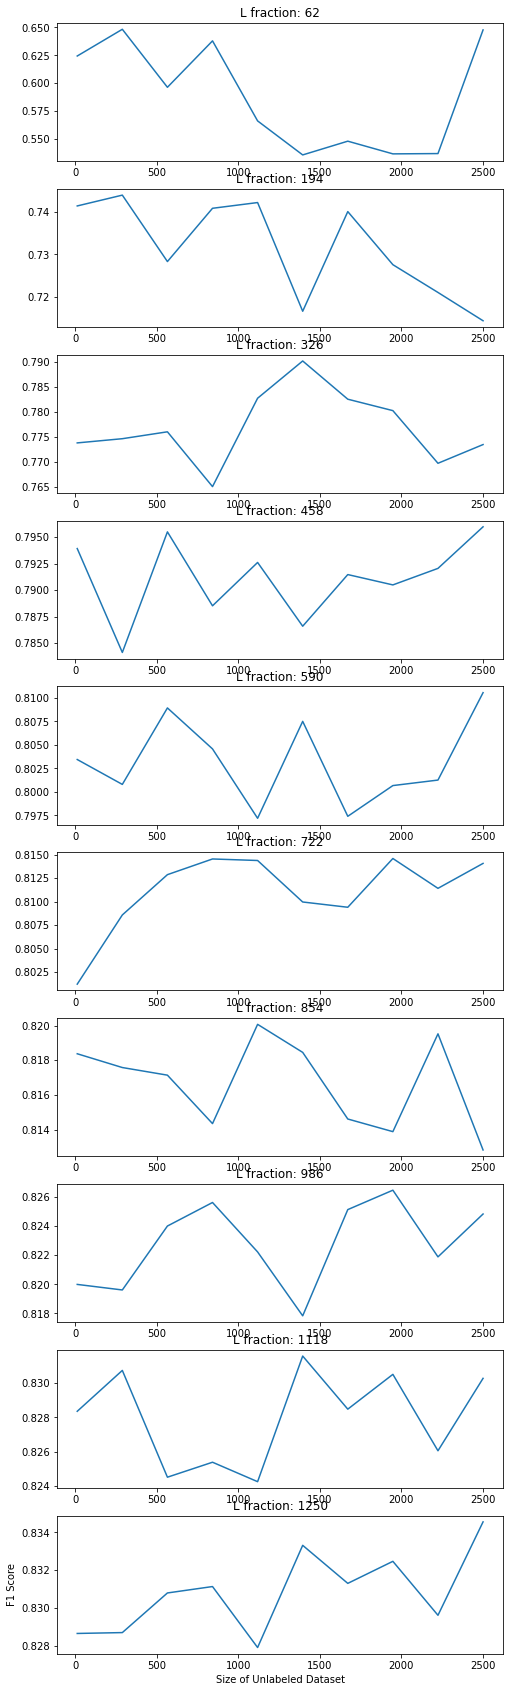

In [67]:
fig, ax = pl.subplots(10, 1, figsize=(8,30))
for i, k in enumerate(f1_scores.keys()):
    ax[i].plot(12500*np.linspace(0.001, 0.2, 10), roc_scores[k])
    ax[i].set_title('L fraction: {:}'.format(int(k*12500)))
pl.xlabel('Size of Unlabeled Dataset')
pl.ylabel('F1 Score')
pl.savefig('f1_usize_multi.pdf')